## Overview

- **Main ideas:**
    - This notebook makes the `MERRA2` data for variable of `mean air temperature at 2 m` (daily resolution) spatially compatible with `ERA-INTERIM` data grid: 
        - MERRA2:
            - lat: 361, lon: 576; 0.5 x 0.625 degrees; global.
        - ERA-INTERIM: 
            - lat: 241, lon: 480; 0.75 x 0.75 degrees; global. 

## Initial setup

In [40]:
%%time

# Load packages
import sys
import glob
import os
import contextlib
import progressbar

import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.diagnostics import ProgressBar

xr.set_options(display_style="text")

%matplotlib inline

CPU times: user 2.08 ms, sys: 0 ns, total: 2.08 ms
Wall time: 2.09 ms


In [2]:
print("Python:", sys.version)
print("Xarray:", xr.__version__)
print("Pandas:", pd.__version__)

Python: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
Xarray: 0.16.0
Pandas: 1.0.2


In [3]:
# My repository.
repository = "/home/alex/Dropbox/repositories/cdlearn/"

In [4]:
%%time

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
from cdlearn.maps import south_america_months

CPU times: user 1.71 s, sys: 187 ms, total: 1.9 s
Wall time: 1.97 s


In [5]:
# Data folder.
MAIN_FOLDER = "/media/alex/ALEXDATA/data_sets/MERRA2/"

# Put regridded data here.
OUTPUT_FOLDER = "/media/alex/ALEXDATA/data_sets/MERRA2/"

# One file for each month.
FILES_PATHS = sorted([
    os.path.join(MAIN_FOLDER, FILE) for FILE in os.listdir(MAIN_FOLDER) 
    if "_slv_" in FILE
])

In [6]:
# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

## Explore single file

In [7]:
%%time

# Lazy load. The chunks option make data as dask arrays instead of numpy arrays.
# So when transposing the data is not loaded into memory!
DS = xr.open_dataset(
    filename_or_obj=FILES_PATHS[-1]
)

# Now you can transpose without loading into memory.
DS = DS.transpose("time", "lat", "lon")

# Show it.
print(">>> Data:")
print(DS)

>>> Data:
<xarray.Dataset>
Dimensions:     (lat: 361, lon: 576, time: 1)
Coordinates:
  * lon         (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat         (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time        (time) datetime64[ns] 2020-06-30T12:00:00
Data variables:
    HOURNORAIN  (time, lat, lon) float32 ...
    T2MMAX      (time, lat, lon) float32 ...
    T2MMEAN     (time, lat, lon) float32 ...
    T2MMIN      (time, lat, lon) float32 ...
    TPRECMAX    (time, lat, lon) float32 ...
Attributes:
    nco_openmp_thread_number:          1
    Comment:                           GMAO filename: d5124_m2_jan10.statD_2d...
    History:                           Original file generated: Fri Jul 10 20...
    Filename:                          MERRA2_400.statD_2d_slv_Nx.20200630.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                       

In [8]:
# Into memory.
with ProgressBar():
    DS = DS.load()

In [9]:
# In accordance with ERA-INTERIM pos-processed data (after shifting longitudes from 0 ... 360
# to -180 ... 180).
NEW_GRID = xr.Dataset({
    "lat": (["lat"], np.arange(90.00, -90.01, -0.75)),
    "lon": (["lon"], np.arange(-180.00, 180.00, 0.75)),
})

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Data variables:
    *empty*


In [10]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS, 
    ds_out=NEW_GRID, 
    method="bilinear", 
    periodic=True, 
    reuse_weights=True,
    filename="regridder_t2m.nc"
)

Reuse existing file: regridder_t2m.nc
CPU times: user 15.3 ms, sys: 12 ms, total: 27.3 ms
Wall time: 27.4 ms


In [11]:
%%time

# Regridded data.
DSreg = REGRIDDER(DS)

# Show it.
print(DSreg)

using dimensions ('lat', 'lon') from data variable HOURNORAIN as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:     (lat: 241, lon: 480, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2020-06-30T12:00:00
  * lon         (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
  * lat         (lat) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Data variables:
    HOURNORAIN  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    T2MMAX      (time, lat, lon) float64 273.1 273.1 273.1 ... 223.4 223.4 223.4
    T2MMEAN     (time, lat, lon) float64 272.8 272.8 272.8 ... 221.3 221.3 221.3
    T2MMIN      (time, lat, lon) float64 272.4 272.4 272.4 ... 219.7 219.7 219.7
    TPRECMAX    (time, lat, lon) float64 1.19e-05 1.19e-05 ... 1.1e-07 1.1e-07
Attributes:
    regrid_method:  bilinear
CPU times: user 19.6 ms, sys: 3.49 ms, total: 23.1 ms
Wall time: 33.3 ms


## Compare original and regridded files

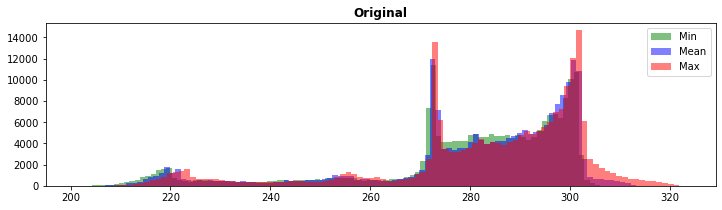

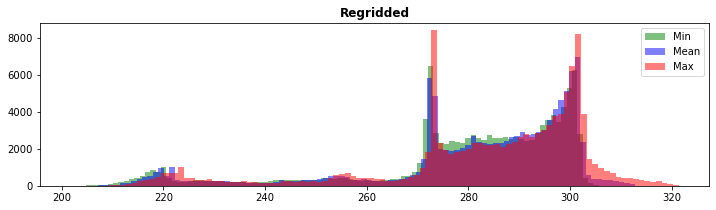

In [22]:
# Histograms.
plt.figure(figsize=(12, 3))
plt.hist(DS.T2MMIN.values.flatten(), bins=100, color="green", alpha=0.5, 
         label="Min")
plt.hist(DS.T2MMEAN.values.flatten(), bins=100, color="blue", alpha=0.5, 
         label="Mean")
plt.hist(DS.T2MMAX.values.flatten(), bins=100, color="red", alpha=0.5, 
         label="Max")
plt.title("Original", weight="bold");
plt.legend();

plt.figure(figsize=(12, 3))
plt.hist(DSreg.T2MMIN.values.flatten(), bins=100, color="green", alpha=0.5, 
         label="Min")
plt.hist(DSreg.T2MMEAN.values.flatten(), bins=100, color="blue", alpha=0.5, 
         label="Mean")
plt.hist(DSreg.T2MMAX.values.flatten(), bins=100, color="red", alpha=0.5, 
         label="Max")
plt.title("Regridded", weight="bold");
plt.legend();

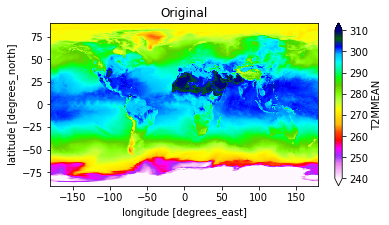

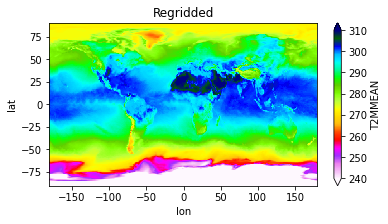

In [31]:
# Mean of the day.
plt.figure(figsize=(6, 3))
DS.T2MMEAN.mean("time").plot(vmin=240, vmax=310, cmap=plt.cm.gist_ncar_r)
plt.title("Original");

# Mean of the day.
plt.figure(figsize=(6, 3))
DSreg.T2MMEAN.mean("time").plot(vmin=240, vmax=310, cmap=plt.cm.gist_ncar_r)
plt.title("Regridded");

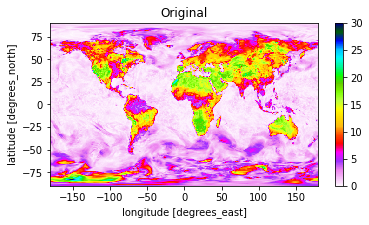

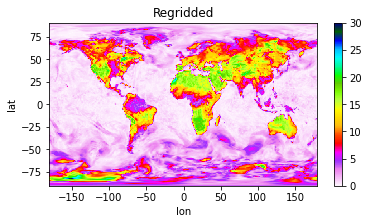

In [32]:
# Amplitude of the day.
plt.figure(figsize=(6, 3))
(DS.T2MMAX - DS.T2MMIN).mean("time").plot(vmin=0, vmax=30, cmap=plt.cm.gist_ncar_r)
plt.title("Original");

# Amplitude of the day.
plt.figure(figsize=(6, 3))
(DSreg.T2MMAX - DSreg.T2MMIN).mean("time").plot(vmin=0, vmax=30, cmap=plt.cm.gist_ncar_r)
plt.title("Regridded");

## Create regridded files for all years

**It takes a lot of time to make all files (~1h30min)!**

In [42]:
%%time

# Progress during building of files.
bar = progressbar.ProgressBar(max_value=len(FILES_PATHS))

# Loop over input files.
for i, FILE_PATH in enumerate(FILES_PATHS):
    
    # Extract input file name without extension.
    NAME = os.path.basename(FILE_PATH) # File name with extension.
    NAME = os.path.splitext(NAME)[0]   # File name withou extension.
    
    # Output file path.
    OUT_FILE_NAME = NAME + "_regridded" + ".nc4"
    OUT_FILE_PATH = OUTPUT_FOLDER + OUT_FILE_NAME   
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(OUT_FILE_PATH):
                
        # Load data.
        DS = xr.open_dataset(
            filename_or_obj=FILE_PATH
        )

        # Now you can transpose without loading into memory.
        DS = DS.transpose("time", "lat", "lon")
          
        # Regrid data without printing messages.    
        with open(os.devnull, "w") as devnull:
            with contextlib.redirect_stdout(devnull):
                DSreg = REGRIDDER(DS)
    
        # Export regridded data into the output folder. 
        DSreg.to_netcdf(path=OUT_FILE_PATH)
        
        # Next one.
        bar.update(i) 

 99% (14791 of 14792) |################# | Elapsed Time: 1:29:53 ETA:   0:00:00

CPU times: user 30min 19s, sys: 2min 13s, total: 32min 32s
Wall time: 1h 29min 54s
